# DCGAN

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
def build_generator(inputs, image_shape):
  img_r = image_shape//4
  kernels = [128, 64, 32, 1]
  kernel_size = 5
  x = layers.Dense(img_r*img_r*kernels[0])(inputs)
  x = layers.Reshape((img_r,img_r,kernels[0]))(x)
  for kernel in kernels:
    if kernel >= kernels[1]:
      strides=2
    else:
      strides=1
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(kernel, kernel_size, strides=strides, padding='same')(x)
  x = layers.Activation('sigmoid')(x)
  generator = keras.Model(inputs, x, name='Generator')
  return generator

In [3]:
inputs = layers.Input(shape=(100,))
G = build_generator(inputs, 28)

In [4]:
G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      409728    
 nspose)                                                 

In [5]:
def build_discriminator(inputs):
  kernels = [32,64,128,256]
  kernel_size = 5
  x = inputs
  for kernel in kernels:
    if kernel >= kernels[1]:
      strides=2
    else:
      strides=1
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(kernel, kernel_size, strides=strides, padding='same')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  discriminator = keras.Model(inputs, x, name='Discriminator')
  return discriminator

In [6]:
inputs = layers.Input(shape=(28,28,1))
D = build_discriminator(inputs)

In [7]:
D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)       

In [8]:
class DCGAN:
  def __init__(self, image_shape=(28,28,1)):
    self.latent_vector = (100,)
    self.image_shape = image_shape
    self.inputs = layers.Input(shape=self.latent_vector)
    self.generator = build_generator(self.inputs, image_shape[0])
    inputs = layers.Input(shape=image_shape)
    self.discriminator = build_discriminator(inputs)

  @staticmethod
  def build_generator(inputs, image_shape):
    img_r = image_shape//4
    kernels = [128, 64, 32, 1]
    kernel_size = 5
    x = layers.Dense(img_r*img_r*kernels[0])(inputs)
    x = layers.Reshape((img_r,img_r,kernels[0]))(x)
    for kernel in kernels:
      if kernel >= kernels[1]:
        strides=2
      else:
        strides=1
      x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      x = layers.Conv2DTranspose(kernel, kernel_size, strides=strides, padding='same')(x)
    x = layers.Activation('sigmoid')(x)
    generator = keras.Model(inputs, x, name='Generator')
    return generator
  
  @staticmethod
  def build_discriminator(inputs):
    kernels = [32,64,128,256]
    kernel_size = 5
    x = inputs
    for kernel in kernels:
      if kernel >= kernels[1]:
        strides=2
      else:
        strides=1
      x = layers.LeakyReLU()(x)
      x = layers.Conv2D(kernel, kernel_size, strides=strides, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    discriminator = keras.Model(inputs, x, name='Discriminator')
    return discriminator

  def compile(self):
    lr = 1e-4
    decay = 7e-8
    optimizer = optimizers.Adam(lr, decay=decay)
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
    self.discriminator.trainable=False
    self.adversarial = keras.Model(self.inputs, self.discriminator(self.generator(self.inputs)))
    optimizer = optimizers.Adam(lr*0.5, decay=decay*0.5)
    self.adversarial.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
    self.adversarial.summary()

  def train(self, X, batch_size, epochs):
    input_noise = np.random.uniform(-1.0, 1.0, size=[64, self.latent_vector[0]])
    X_size = X.shape[0]
    steps = X_size//batch_size
    for e in range(epochs):
      lossD, accD = 0, 0
      lossA, accA = 0, 0
      for i in range(steps):
        random_idx = np.random.randint(0, X_size, size=batch_size)
        real_imgs = X[random_idx]
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.latent_vector[0]])
        fake_imgs = self.generator.predict(noise)
        # Creamos el conjunto de datos 
        x = np.concatenate((real_imgs, fake_imgs))
        # Etiquetamos
        y = np.ones([2*batch_size, 1])
        y[batch_size:,:] = 0.0
        # Entrenamiento del discriminador
        lossd, accd = self.discriminator.train_on_batch(x,y)
        lossD += lossd
        accD += accd
        # Entramiento del adversarial
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.latent_vector[0]])
        y = np.ones([batch_size, 1])
        lossa, acca = self.adversarial.train_on_batch(noise,y)
        lossA += lossa
        accA += acca
      lossD, accD = lossD/steps, accD/steps
      lossA, accA = lossA/steps, accA/steps
      print("Step {}: [D] Loss:{}, Acc:{}".format(e,lossD,accD))
      print("Step {}: [A] Loss:{}, Acc:{}".format(e,lossA,accA))
      self.generator.save('Generator_e{}.h5'.format(e+1))
      # Graficar imagenes
      noise = np.random.uniform(-1.0, 1.0, size=[25, self.latent_vector[0]])
      fig, ax = plt.subplots(5,5)
      fake_imgs = self.generator.predict(noise)
      for i in range(5):
        for j in range(5):
          ax[i,j].imshow(fake_imgs[i+5*j,:,:,0], cmap='gray')
      plt.show()
  
  def load_mnist(self):
    (X,_), (_,_) = mnist.load_data()
    w,h,c = self.image_shape
    X = X.reshape((-1,w,h,c))
    self.X = X.astype('float32')/255
    return self.X

In [9]:
dcgan = DCGAN()

In [10]:
dcgan.compile()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 Generator (Functional)      (None, 28, 28, 1)         1301505   
                                                                 
 Discriminator (Functional)  (None, 1)                 1338753   
                                                                 
Total params: 2,640,258
Trainable params: 1,300,801
Non-trainable params: 1,339,457
_________________________________________________________________


In [11]:
X = dcgan.load_mnist()

Step 0: [D] Loss:0.08703267808801915, Acc:0.9743279749199573
Step 0: [A] Loss:1.5678360834125253, Acc:0.6404082177161152


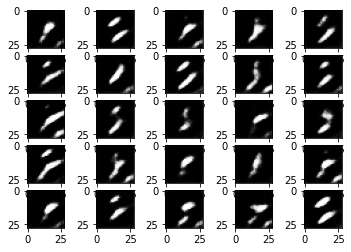

Step 1: [D] Loss:0.22663616991165544, Acc:0.9082010405549626
Step 1: [A] Loss:2.1075786686996385, Acc:0.18719983991462114


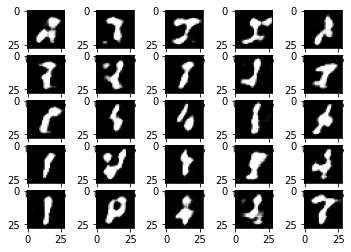

Step 2: [D] Loss:0.27672024844104987, Acc:0.886406083244397
Step 2: [A] Loss:1.9833173699987101, Acc:0.14827908217716115


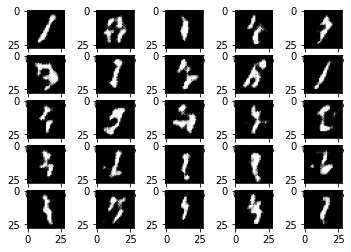

Step 3: [D] Loss:0.2608258373550315, Acc:0.8930096051227321
Step 3: [A] Loss:2.39510929177385, Acc:0.109375


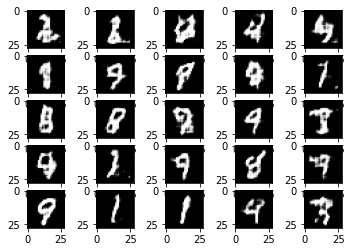

Step 4: [D] Loss:0.31194589103362347, Acc:0.8670791088580576
Step 4: [A] Loss:2.1135079059173356, Acc:0.12491662219850587


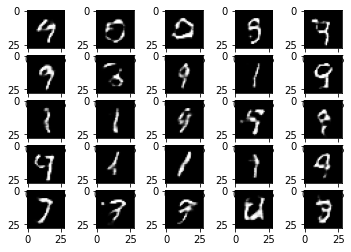

Step 5: [D] Loss:0.35700387915590404, Acc:0.8446504802561366
Step 5: [A] Loss:1.8826720339257028, Acc:0.1605356189967983


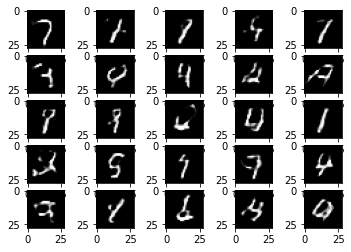

Step 6: [D] Loss:0.3633904607217111, Acc:0.8426827641408752
Step 6: [A] Loss:1.6436883160882214, Acc:0.21222985592315902


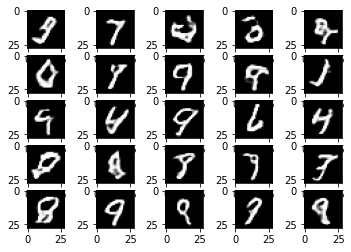

Step 7: [D] Loss:0.37704223734719267, Acc:0.832485659018143
Step 7: [A] Loss:1.8245772165320853, Acc:0.15258137673425828


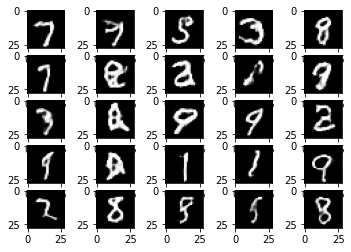

Step 8: [D] Loss:0.3891268939479565, Acc:0.8238810699039488
Step 8: [A] Loss:1.8198809614812552, Acc:0.1549659818569904


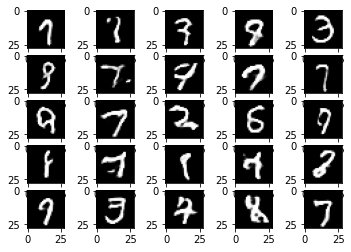

Step 9: [D] Loss:0.4076681475501941, Acc:0.8120080709711847
Step 9: [A] Loss:1.7204576954643143, Acc:0.15903481856990395


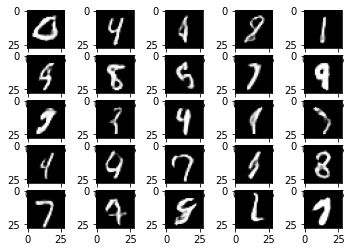

Step 10: [D] Loss:0.42265410223536454, Acc:0.8020610992529349
Step 10: [A] Loss:1.633227995009407, Acc:0.16914020811099253


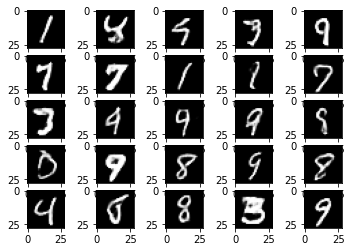

Step 11: [D] Loss:0.4292191334124436, Acc:0.7977671424759872
Step 11: [A] Loss:1.6007285188076463, Acc:0.17606056563500533


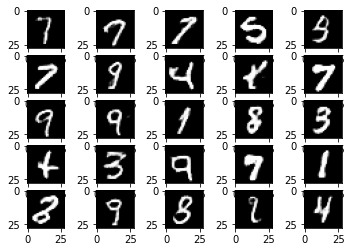

Step 12: [D] Loss:0.443145324160984, Acc:0.7881203308431163
Step 12: [A] Loss:1.5466790765428493, Acc:0.18433164354322304


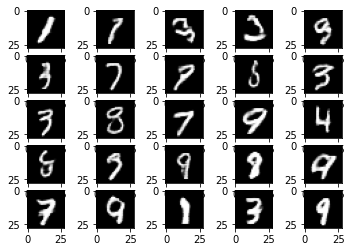

Step 13: [D] Loss:0.4482129163077954, Acc:0.7841015208110993
Step 13: [A] Loss:1.508788954740909, Acc:0.18082977588046958


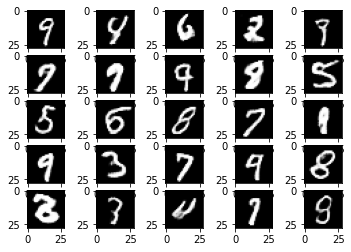

Step 14: [D] Loss:0.4567641680752073, Acc:0.7779899279615795
Step 14: [A] Loss:1.5068208486191619, Acc:0.19308631270010673


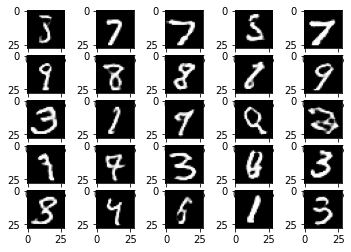

Step 15: [D] Loss:0.4568780939250771, Acc:0.7776063900747066
Step 15: [A] Loss:1.4660594427089426, Acc:0.19330309498399145


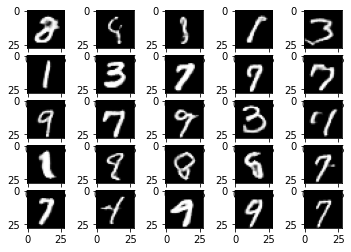

Step 16: [D] Loss:0.4625384779915357, Acc:0.7721701574172892
Step 16: [A] Loss:1.4632724572525717, Acc:0.1941535485592316


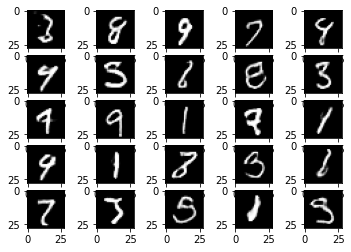

Step 17: [D] Loss:0.47107517175384367, Acc:0.770327508004269
Step 17: [A] Loss:1.4441288864218185, Acc:0.21608191035218782


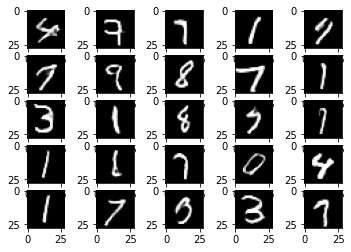

Step 18: [D] Loss:0.4537879465547417, Acc:0.7793906750266809
Step 18: [A] Loss:1.4297735110927163, Acc:0.22090114727854857


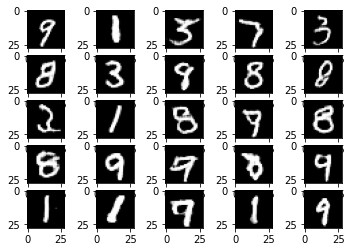

Step 19: [D] Loss:0.45918158348749133, Acc:0.7727538020277481
Step 19: [A] Loss:1.4598180992626202, Acc:0.19912286552828176


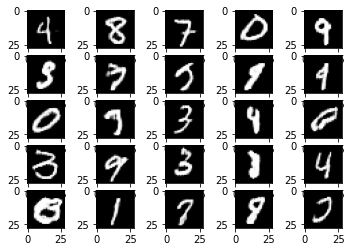

Step 20: [D] Loss:0.45301803275386193, Acc:0.7772061766275347
Step 20: [A] Loss:1.4893250284098256, Acc:0.18516542155816434


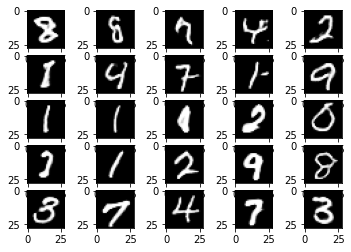

Step 21: [D] Loss:0.4453589654783047, Acc:0.7820921157950907
Step 21: [A] Loss:1.5011545051378272, Acc:0.1848819370330843


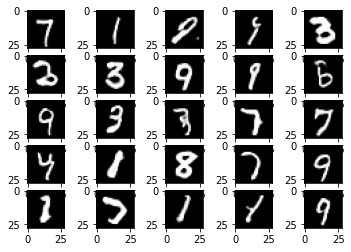

Step 22: [D] Loss:0.4467800903345757, Acc:0.7808747998932765
Step 22: [A] Loss:1.5339803161972234, Acc:0.18701640875133405


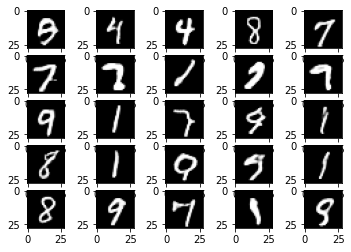

Step 23: [D] Loss:0.4447934279256086, Acc:0.7812583377801494
Step 23: [A] Loss:1.5245449397327298, Acc:0.18291422091782283


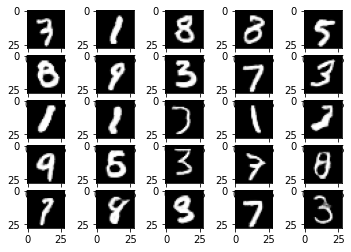

Step 24: [D] Loss:0.44641609532856, Acc:0.7799242929562433
Step 24: [A] Loss:1.5320503222522512, Acc:0.18348118996798293


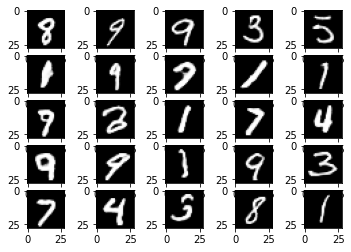

In [12]:
dcgan.train(X, 64, 25)

In [34]:
ruido = np.random.uniform(-1.,1.,(1,100))
f_img = dcgan.generator.predict(ruido)

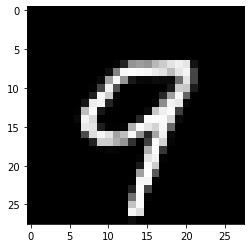

In [35]:
plt.imshow(f_img[0,:,:,0], cmap='gray')